# split_dataset.py — Dataset splitting and export
This notebook converts the original `split_dataset.py` script into runnable cells with explanations.

It splits the dataset at the *patient* level (so all images from a patient go to the same subset) and aims to stratify by the dominant (Label, image_type) combo per patient to avoid leakage of image types across splits.

Edit the configuration cell before running any cells.

### Imports
Import required libraries used throughout the notebook. If some optional libs (e.g., seaborn) are not installed, the code will still run, but plots may be limited.

In [1]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Optional plotting libs
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except Exception:
    sns = None

# Display helper for environments that support rich display
try:
    from IPython.display import display
except Exception:
    display = lambda x: print(x)


### Configuration variables and paths
Edit these variables before running the notebook. You can also override them with environment variables (see the example). Make sure TRAIN_RATIO + VAL_RATIO + TEST_RATIO == 1.0.

In [2]:
# --- Configuration (adjust as needed) ---
BASE_PATH = os.getenv("BASE_PATH", "/mounts/monica/MIQR-CC DATASET")
CSV_PATH = os.getenv("CSV_PATH", os.path.join(BASE_PATH, "metadata.csv"))
PROCESSED_DIR = os.getenv("PROCESSED_DIR", os.path.join(BASE_PATH, "processed"))
OUTPUT_BASE = os.getenv("OUTPUT_BASE", "/mounts/monica/ERCP image classification/dataset")

TRAIN_RATIO = float(os.getenv("TRAIN_RATIO", 0.7))
VAL_RATIO = float(os.getenv("VAL_RATIO", 0.15))
TEST_RATIO = float(os.getenv("TEST_RATIO", 0.15))
RANDOM_STATE = int(os.getenv("RANDOM_STATE", 42))

# Dry-run mode: if True, the notebook will not perform filesystem writes (useful for previews)
DRY_RUN = os.getenv("DRY_RUN", "False").lower() in ("1", "true", "yes")

assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-6, "TRAIN+VAL+TEST must sum to 1.0"

print(f"BASE_PATH={BASE_PATH}\nCSV_PATH={CSV_PATH}\nOUTPUT_BASE={OUTPUT_BASE}\nTRAIN/VAL/TEST={TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}\nRANDOM_STATE={RANDOM_STATE}\nDRY_RUN={DRY_RUN}")

BASE_PATH=/mounts/monica/MIQR-CC DATASET
CSV_PATH=/mounts/monica/MIQR-CC DATASET/metadata.csv
OUTPUT_BASE=/mounts/monica/ERCP image classification/dataset
TRAIN/VAL/TEST=0.7/0.15/0.15
RANDOM_STATE=42
DRY_RUN=False


### Sanitize label helper
Filesystem-safe label names are useful for folder names. The helper below replaces non-alphanumeric characters with underscores but preserves '.', '_' and '-'.

In [3]:
def sanitize_label(s):
    """Return a filesystem-safe label name."""
    return "".join(c if str(c).isalnum() or c in "._-" else "_" for c in str(s).strip())

# Quick examples
print(sanitize_label('Malignant Stricture'))
print(sanitize_label('Normal'))

Malignant_Stricture
Normal


### Load metadata CSV into a DataFrame
Read the `metadata.csv` file and inspect the DataFrame briefly. The notebook will skip processing if the CSV is not found.

In [4]:
if not os.path.exists(CSV_PATH):
    print(f"CSV not found at {CSV_PATH}. Set BASE_PATH/CSV_PATH correctly before proceeding.")
    df = None
else:
    df = pd.read_csv(CSV_PATH)
    print('DataFrame loaded:')
    print(df.shape)
    display(df.head())
    print('\nColumns of interest:', [c for c in ['patient_id', 'Label', 'image_type', 'Keep', 'processed_image_path'] if c in df.columns])

DataFrame loaded:
(19317, 12)


,raw_image_path,processed_image_path,patient_id,image_type,sex,birth_date,exam_date,exam_time,age,equipment_model,Label,Keep
0,raw/1_image1.png,processed/1_image1.png,1,S,M,22/08/1952,03/02/2022,11:50:32,69.0,Ziehm Vision RFD,Unlabelled,Keep
1,raw/1_image2.png,processed/1_image2.png,1,S,M,22/08/1952,03/02/2022,11:47:43,69.0,Ziehm Vision RFD,Unlabelled,Keep
2,raw/1_image3.png,processed/1_image3.png,1,S,M,22/08/1952,03/02/2022,12:08:45,69.0,Ziehm Vision RFD,Unlabelled,Keep
3,raw/1_image4.png,processed/1_image4.png,1,S,M,22/08/1952,03/02/2022,11:50:22,69.0,Ziehm Vision RFD,Unlabelled,Keep
4,raw/2_image5.png,processed/2_image5.png,2,S,F,15/08/1925,21/06/2022,20:09:00,96.0,Ziehm Vision RFD,Lithiasis,Discard



Columns of interest: ['patient_id', 'Label', 'image_type', 'Keep', 'processed_image_path']


### Filter and clean the metadata
Keep only rows with `Keep == 'Keep'` and `Label != 'Unlabelled'`. Show before/after counts to verify filtering.

In [5]:
if df is None:
    print('No data loaded; skipping filter step.')
else:
    before = df.shape[0]
    df = df[(df['Keep'] == 'Keep') & (df['Label'] != 'Unlabelled')].copy()
    after = df.shape[0]
    print(f'Filtered rows: before={before}, after={after}')
    print('\nLabel distribution before/after:')
    # Note: we only had df after load, so show current distribution
    print(df['Label'].value_counts())

Filtered rows: before=19317, after=1568

Label distribution before/after:
Label
Lithiasis              726
Malignant Stricture    329
Normal                 299
Biliary Leaks          151
Benign Stricture        63
Name: count, dtype: int64


### Merge 'Stricture' labels
Some labels are consolidated for clarity (e.g., 'Malignant Stricture' and 'Benign Stricture' become 'Stricture').

In [6]:
if df is None:
    print('No data loaded; skipping label consolidation.')
else:
    df['Label'] = df['Label'].replace({
        'Malignant Stricture': 'Stricture',
        'Benign Stricture': 'Stricture'
    })
    print('Label distribution after merge:')
    print(df['Label'].value_counts())

Label distribution after merge:
Label
Lithiasis        726
Stricture        392
Normal           299
Biliary Leaks    151
Name: count, dtype: int64


### Patient-level dominant (Label, image_type) combo
We compute the most frequent (Label, image_type) per patient and use it as a stratification key to keep both label and image type balanced across splits.

In [7]:
if df is None:
    print('No data loaded; cannot compute patient-level combos.')
else:
    combo_counts = (
        df.groupby(['patient_id', 'Label', 'image_type']).size().reset_index(name='count')
    )
    patient_df = (
        combo_counts.sort_values(['patient_id', 'count'], ascending=[True, False])
        .drop_duplicates('patient_id')
        .reset_index(drop=True)
    )
    patient_df['combo'] = patient_df['Label'].astype(str) + '__' + patient_df['image_type'].astype(str)
    print('Patient-level combos computed. Sample:')
    display(patient_df.head())


Patient-level combos computed. Sample:


,patient_id,Label,image_type,count,combo
0,3,Normal,S,1,Normal__S
1,5,Stricture,S,1,Stricture__S
2,6,Normal,S,1,Normal__S
3,9,Stricture,S,2,Stricture__S
4,16,Stricture,S,6,Stricture__S


### Split patients into train / val / test with stratified fallback
We perform a two-stage split: first train vs temp, stratifying by the patient-level 'combo' where possible; if stratify fails (too few samples per stratum), we fall back to stratifying by Label.

In [8]:
if df is None:
    print('No data loaded; skipping splits.')
else:
    try:
        train_patients, temp_patients = train_test_split(
            patient_df,
            test_size=(1 - TRAIN_RATIO),
            stratify=patient_df['combo'],
            random_state=RANDOM_STATE,
        )
    except ValueError:
        print("Warning: stratify by (Label__image_type) failed (too few samples per stratum). Falling back to stratify by Label.")
        train_patients, temp_patients = train_test_split(
            patient_df,
            test_size=(1 - TRAIN_RATIO),
            stratify=patient_df['Label'],
            random_state=RANDOM_STATE,
        )

    try:
        val_patients, test_patients = train_test_split(
            temp_patients,
            test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
            stratify=temp_patients['combo'],
            random_state=RANDOM_STATE,
        )
    except ValueError:
        print("Warning: stratify by (Label__image_type) failed for temp split. Falling back to stratify by Label.")
        val_patients, test_patients = train_test_split(
            temp_patients,
            test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
            stratify=temp_patients['Label'],
            random_state=RANDOM_STATE,
        )

    print('Patient counts:')
    print('train:', len(train_patients), 'val:', len(val_patients), 'test:', len(test_patients))

Patient counts:
train: 305 val: 65 test: 66


### Map patient splits and assign split to each row
Create a `splits` dict with patient_id sets, then add a `split` column to `df` so each image row knows its subset.

In [9]:
if df is None:
    print('No data loaded; cannot assign splits to rows.')
else:
    splits = {
        'train': set(train_patients['patient_id']),
        'val': set(val_patients['patient_id']),
        'test': set(test_patients['patient_id'])
    }

    # helper to find split for a patient
    def patient_split(pid):
        for s, patients in splits.items():
            if pid in patients:
                return s
        return None

    df['split'] = df['patient_id'].apply(patient_split)
    print('Counts per split (rows):')
    print(df['split'].value_counts(dropna=False))

Counts per split (rows):
split
train    1067
test      267
val       234
Name: count, dtype: int64


### Create output folder structure (sanitized label names)
Create directories under OUTPUT_BASE for each split and label. In DRY_RUN mode this only prints what would be created.

In [10]:
if df is None:
    print('No data loaded; skipping directory creation.')
else:
    labels = sorted(df['Label'].unique())
    label_to_dir = {lbl: sanitize_label(lbl) for lbl in labels}

    for split in ['train', 'val', 'test']:
        for label, dir_name in label_to_dir.items():
            out_dir = os.path.join(OUTPUT_BASE, split, dir_name)
            if DRY_RUN:
                print('DRY_RUN: would create', out_dir)
            else:
                os.makedirs(out_dir, exist_ok=True)
    print('Directory creation step completed (or simulated).')

Directory creation step completed (or simulated).


### Copy or link images into split folders (with DRY_RUN option)
This step copies files from PROCESSED_DIR to OUTPUT_BASE/{split}/{label_dir}. If `DRY_RUN` is True the notebook will only report what would be copied.


In [11]:
copied = 0
skipped = 0
missing = 0
examples = []

if df is None:
    print('No data loaded; skipping copying.')
else:
    for _, row in df.iterrows():
        pid = row['patient_id']
        split = row.get('split')
        if not split:
            skipped += 1
            continue

        src = os.path.join(BASE_PATH, row['processed_image_path']) if 'processed_image_path' in row else os.path.join(PROCESSED_DIR, row.get('filename', ''))
        label_dir = label_to_dir.get(row['Label'], sanitize_label(row['Label']))
        dst_name = f"{pid}_{os.path.basename(row.get('processed_image_path', ''))}"
        dst = os.path.join(OUTPUT_BASE, split, label_dir, dst_name)

        if os.path.exists(src):
            if DRY_RUN:
                copied += 1
                examples.append((src, dst))
            else:
                try:
                    shutil.copy2(src, dst)
                    copied += 1
                except Exception as e:
                    print('Failed to copy', src, '->', dst, 'error:', e)
        else:
            missing += 1

    print(f"Copy summary: would_copy={copied if DRY_RUN else copied}, missing_src={missing}, skipped_rows={skipped}")
    if DRY_RUN:
        print('Sample planned copies (up to 5):')
        for s, d in examples[:5]:
            print(s, '->', d)


Copy summary: would_copy=1568, missing_src=0, skipped_rows=0


In [12]:
import cv2
from pathlib import Path
from tqdm.notebook import tqdm


def resize_and_pad(image_path, size=512, write=True):
    """Resize an image keeping aspect ratio and pad with black to make it square (size x size).
    If write is False the function will validate loading/resizing but won't overwrite the file (useful for DRY_RUN).
    Returns True on success, False otherwise."""
    image_path = Path(image_path)
    img = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    if img is None:
        print(f"Erro ao carregar imagem: {image_path}")
        return False

    h, w = img.shape[:2]
    scale = size / max(h, w)
    new_w, new_h = max(1, int(w * scale)), max(1, int(h * scale))
    interp = cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC
    resized = cv2.resize(img, (new_w, new_h), interpolation=interp)

    top_pad = (size - new_h) // 2
    bottom_pad = size - new_h - top_pad
    left_pad = (size - new_w) // 2
    right_pad = size - new_w - left_pad

    padded = cv2.copyMakeBorder(
        resized, top_pad, bottom_pad, left_pad, right_pad,
        cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    # Ensure final size exactly matches
    if padded.shape[0] != size or padded.shape[1] != size:
        padded = cv2.resize(padded, (size, size), interpolation=cv2.INTER_AREA)

    if write:
        cv2.imwrite(str(image_path), padded)
    return True


# Apply to all images in OUTPUT_BASE/{train,val,test}
if df is None:
    print('No data loaded; skipping padding+resize step.')
else:
    candidates = []
    for split in ['train', 'val', 'test']:
        split_dir = Path(OUTPUT_BASE) / split
        if not split_dir.exists():
            print(f"Split folder not found: {split_dir}")
            continue
        for p in split_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}:
                candidates.append(p)

    print(f"Found {len(candidates)} images to process (DRY_RUN={DRY_RUN}).")

    processed = 0
    failed = 0
    for p in tqdm(candidates, desc='pad+resize'):
        try:
            ok = resize_and_pad(p, size=512, write=not DRY_RUN)
            if ok:
                processed += 1
            else:
                failed += 1
        except Exception as e:
            failed += 1
            print(f"Error processing {p}: {e}")

    print(f"Done. Processed: {processed}, Failed: {failed}")

ModuleNotFoundError: No module named 'cv2'

### Sanity checks: overlaps and distribution tables
Check for overlapping patient assignments across splits and print label and image_type distributions per subset.

In [ ]:
if df is None:
    print('No data loaded; skipping sanity checks.')
else:
    overlaps = (
        len(splits['train'] & splits['val']) +
        len(splits['train'] & splits['test']) +
        len(splits['val'] & splits['test'])
    )
    if overlaps > 0:
        print(f"Warning: {overlaps} overlapping patient assignments between splits!")

    print('\nDistribution per subset / label:')
    for split in ['train', 'val', 'test']:
        subset_df = df[df['patient_id'].isin(splits[split])]
        print(f"\n{split.upper()}")
        print(subset_df['Label'].value_counts())

    print('\nDistribution per image_type:')
    for split in ['train', 'val', 'test']:
        subset_df = df[df['patient_id'].isin(splits[split])]
        print(f"\n{split.upper()}")
        print(subset_df['image_type'].value_counts())


Distribution per subset / label:

TRAIN
Label
Lithiasis        505
Stricture        255
Normal           197
Biliary Leaks    110
Name: count, dtype: int64

VAL
Label
Lithiasis        98
Normal           59
Stricture        53
Biliary Leaks    24
Name: count, dtype: int64

TEST
Label
Lithiasis        123
Stricture         84
Normal            43
Biliary Leaks     17
Name: count, dtype: int64

Distribution per image_type:

TRAIN
image_type
S    1034
V      33
Name: count, dtype: int64

VAL
image_type
S    231
V      3
Name: count, dtype: int64

TEST
image_type
S    256
V     11
Name: count, dtype: int64


### Optional: Basic assertions and checks
Run a few assertions that are useful for CI-style checks. These are guarded so they do not error when data is not present.


In [ ]:
# Basic checks (guarded)
if df is not None:
    assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-6
    assert len(splits['train'] & splits['val']) == 0
    assert len(splits['train'] & splits['test']) == 0
    assert len(splits['val'] & splits['test']) == 0
    print('Assertions passed: ratio sums and no overlapping patient assignments.')
else:
    print('No data loaded; cannot perform assertions.')

Assertions passed: ratio sums and no overlapping patient assignments.


### Optional: Visualize label and image_type distributions
Plot counts per label and per image_type across splits to inspect class balance.


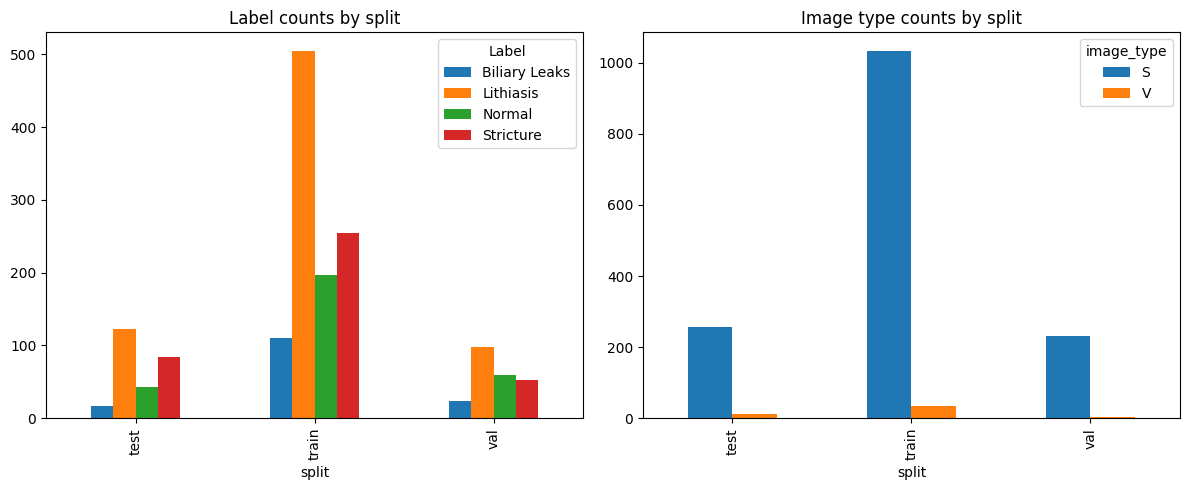

In [ ]:
if df is None:
    print('No data loaded; skipping plots.')
else:
    try:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        label_counts = df.groupby('split')['Label'].value_counts().unstack(fill_value=0)
        label_counts.plot(kind='bar', stacked=False, ax=axes[0])
        axes[0].set_title('Label counts by split')

        itype_counts = df.groupby('split')['image_type'].value_counts().unstack(fill_value=0)
        itype_counts.plot(kind='bar', stacked=False, ax=axes[1])
        axes[1].set_title('Image type counts by split')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Plotting failed:', e)


### Notes & next steps
- Set `DRY_RUN = False` to actually create directories and copy files.
- You can override variables via environment variables or edit the configuration cell directly.
- If stratification fails due to rare combinations, the fallback stratifies by `Label` only.